## 1. Setup and load dependencies

In [22]:
import numpy as np
import pandas as pd
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import re

## 2. Define functions

In [55]:
# ANSI color codes for terminal output
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    RED = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    YELLOW_BG = '\033[93;47m'
    UNDERLINE = '\033[4m'

# function to highlight the text
def highlight_text(original_text, positions):
    highlighted_text = ""
    current_position = 0

    for start, end in positions:
        highlighted_text += original_text[current_position:start]
        highlighted_text += bcolors.OKCYAN + original_text[start:end] + bcolors.ENDC
        current_position = end

    highlighted_text += original_text[current_position:]

    return highlighted_text

# function to match the text by dictionary
def matches_dictionary(text, df_dictionary):
    
    # to make sure the phrases loaded are all lowercase
    df_dictionary['Phrase'] = df_dictionary['Phrase'].str.lower()
    dictionary = df_dictionary.set_index("Phrase").to_dict()["Definition"]

    # Create a regular expression pattern from the dictionary keys
    pattern = re.compile(r'\b(?:' + '|'.join(re.escape(word) for word in dictionary.keys()) + r')\b')

    # Find all matches in the text string along with their positions and definitions
    matches = [(match.start(), match.end(), match.group(), dictionary[match.group()], df_dictionary[df_dictionary["Phrase"].str.lower() == match.group()]['Type'].iloc[0]) for match in pattern.finditer(text.lower())]
    return matches

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

## 3. Data preparation  

Kia ora bro, the weather today is beaut, let’s head to the beach for a surf and catch some awesome mahi!


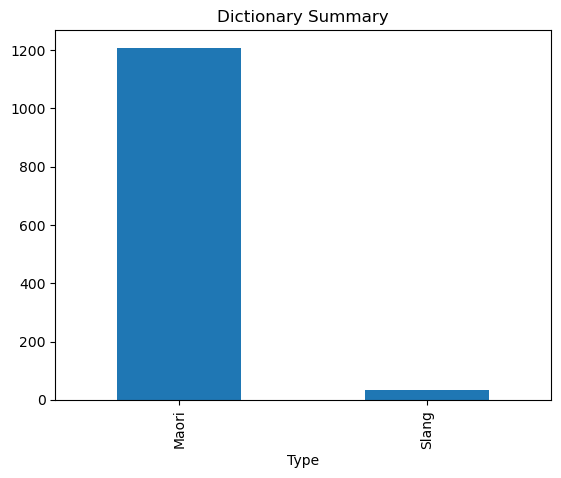

In [62]:
# load data
df_dictionary = pd.read_csv("dictionary.csv")
df_tweets = pd.read_csv("tweets.csv")

# load one message
message_id = 0
message = df_tweets.loc[message_id, 'message']
print(message)

# plot the dictionary by counting word in each type
df_dictionary['Type'].value_counts().plot(kind='bar') 
plt.title('Dictionary Summary')
plt.show()

## 4. Process message to display augmented information

In [63]:
matches = matches_dictionary(message, df_dictionary)
positions = [(start, end) for start, end, _, _, _ in matches]
highlighted_text = highlight_text(message, positions)
print(f"Message Id: {message_id}")
print("")
print( highlighted_text)

# add type word and definition to a data frame
df_matches = pd.DataFrame(matches, columns=["start", "end", "word", "definition", "type"])
df_matches=df_matches.style.set_properties(**{'text-align': 'left', 'header-align': 'left'})
df_matches.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
df_matches


Message Id: 0

Kia ora bro, the weather today is beaut, let’s head to the beach for a surf and catch some awesome mahi!


,start,end,word,definition,type
0,0,3,kia,"Various uses, meanings. Often not translatable by an English word.",Maori
1,4,7,ora,"alive, well, healthy, safe",Maori
2,8,11,bro,"ah, an absolute Kiwi staple. Bro is short for brother and is used to describe your best mates (as well as your actual brother). Probably one of the most used Kiwi slang terms and one of our favourites.",Slang
3,34,39,beaut,used to describe something that is really good. Simple as.,Slang
4,99,103,mahi,"to do, work, make",Maori


## 5. Calculate the sentiment score

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentiment: positive
1) positive 0.9849
2) neutral 0.0133
3) negative 0.0018


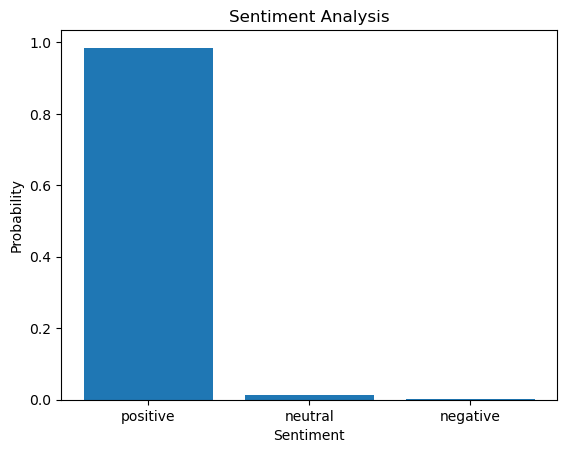

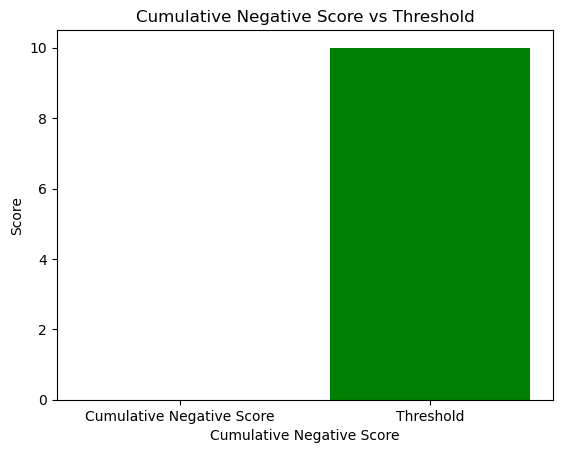

In [65]:
# cumulative negative score
cumulative_negative_score = 0
cumulative_negative_score_threshold = 10

# load the Twitter-roBERTa-base model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
text = preprocess(message)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
ranking = np.argsort(scores)
ranking = ranking[::-1]
print("Sentiment:", config.id2label[ranking[0]])
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

# Bar chart
labels = [config.id2label[ranking[i]] for i in range(scores.shape[0])]
values = [float(scores[ranking[i]]) for i in range(scores.shape[0])]
# Sort labels and values based on sentiment order: positive, neutral, negative
sentiment_order = ['positive', 'neutral', 'negative']
sorted_labels = [label for label in sentiment_order if label in labels]
sorted_values = [values[labels.index(label)] for label in sorted_labels]

plt.bar(sorted_labels, sorted_values)
plt.xlabel('Sentiment')
plt.ylabel('Probability')
plt.title('Sentiment Analysis')


negative_score = sorted_values[2]
cumulative_negative_score +=negative_score

if cumulative_negative_score > cumulative_negative_score_threshold:
    print(bcolors.RED + "WARNING: High cumulative negative score! Please take 10 minutes rest." + bcolors.ENDC)



